# UQRegressors Quickstart

This notebook provides a fast introduction to the key features of UQRegressors for uncertainty-aware regression. In just a few cells, you'll see how to fit a model, make predictions with uncertainty, and visualize the results.

There are five main capabilities of UQRegessors: 

1. **Dataset** loading and validation 
2. **Regression** using models of various types created with UQ capability
3. **Hyperparameter Tuning** using bayesian optimization (wrapper around Optuna)
4. **Metrics** for evaluating goodness of fit and quality of uncertainty intervals
5. **Visualization** of metrics, goodness of fit, and quality of uncertainty intervals

In [3]:
# 1. Import UQRegressors
import numpy as np
import matplotlib.pyplot as plt
from uqregressors.bayesian.dropout import MCDropoutRegressor
from uqregressors.metrics.metrics import compute_all_metrics
from uqregressors.utils.torch_sklearn_utils import train_test_split
from uqregressors.utils.logging import set_logging_config

set_logging_config(print=False)

## Loading a Dataset 
UQRegressors has several methods for loading datasets from various tabular forms, cleaning them, and validating them for use. More detail about Dataset Loading is available in the Getting Started example. For this example, we make a synthetic regression dataset with 8 features, 300 samples, and a small amount of noise. 

In [4]:
# 2. Load Example Dataset
from sklearn.datasets import make_regression

# Generate a small synthetic regression dataset
X, y = make_regression(n_samples=300, n_features=8, noise=10.0, random_state=0)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Training a Regressor
UQRegressors wraps PyTorch and supports a variety of Bayesian and Conformal approaches to uncertainty estimation. Each implementation is highly flexible, validated with published results, and straightforward to set up with a scikit-learn fit, predict interface. All of the supported regressor types are demonstrated in the Getting Started example. A wrapper around Optuna for hyperparameter tuning is also implemented. 

In [5]:
# 3. Train a Regressor with Uncertainty Estimation
mcd = MCDropoutRegressor(
    hidden_sizes=[64, 64],
    dropout=0.05,
    alpha=0.05,  # 95% prediction intervals
    epochs=1000,
    batch_size=32,
    learning_rate=1e-2,
    device="cpu",
    use_wandb=False
)
mcd.fit(X_train, y_train)
print("Model trained. Now, let's try tuning the hyperparameters.")

Model trained. Now, let's try tuning the hyperparameters.


In [19]:
# 3a. Hyperparameter Tuning: Optimize tau for maximum log likelihood
from uqregressors.tuning.tuning import tune_hyperparams, log_likelihood

# Define parameter search space for tau, more detail in Getting Started and Optuna docs
param_space = {
    "tau": lambda trial: trial.suggest_float("tau", 1e1, 1e3, log=True) # typically set a wider range of values
}

# Create a model with default tau (will be overwritten by tuning)
mcd_tune = MCDropoutRegressor(
    hidden_sizes=[64, 64],
    dropout=0.05,
    alpha=0.05,
    epochs=200,  # Short epochs for tuning
    batch_size=32,
    learning_rate=1e-2,
    device="cpu",
    use_wandb=False
)

# Run hyperparameter tuning
opt_model, opt_score, study = tune_hyperparams(
    regressor=mcd_tune,
    param_space=param_space,
    X=X_train,
    y=y_train,
    score_fn=log_likelihood,
    greater_is_better=True,
    n_trials=10,
    n_splits=1,
    verbose=False
)

# Use the best model for final training
mcd = opt_model
mcd.epochs = 1000  # Set to full epochs for final fit

[I 2025-07-09 10:48:43,756] A new study created in memory with name: no-name-2a0494a3-f986-4c7d-83ed-200a877e857d


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-09 10:48:47,714] Trial 0 finished with value: -4.404375498086284 and parameters: {'tau': 83.7452964217357}. Best is trial 0 with value: -4.404375498086284.
[I 2025-07-09 10:48:51,550] Trial 1 finished with value: -4.751707269088777 and parameters: {'tau': 928.6359614276676}. Best is trial 0 with value: -4.404375498086284.
[I 2025-07-09 10:48:55,270] Trial 2 finished with value: -4.8170245913107665 and parameters: {'tau': 176.70514530587985}. Best is trial 0 with value: -4.404375498086284.
[I 2025-07-09 10:48:58,914] Trial 3 finished with value: -4.542158820858813 and parameters: {'tau': 547.914066622478}. Best is trial 0 with value: -4.404375498086284.
[I 2025-07-09 10:49:02,774] Trial 4 finished with value: -4.460069649380017 and parameters: {'tau': 64.14194109988905}. Best is trial 0 with value: -4.404375498086284.
[I 2025-07-09 10:49:06,609] Trial 5 finished with value: -4.90872205530352 and parameters: {'tau': 28.63746770769409}. Best is trial 0 with value: -4.4043754980

## Predicting with a fitted model 

In [20]:
# 4. Make Predictions with Uncertainty
mean, lower, upper = mcd.predict(X_test)
print("Predictions and uncertainty intervals computed.")

Predictions and uncertainty intervals computed.


## Visualization and evaluation

UQRegressors has several methods available to visualize the predictions made and to evaluate their quality (from both point and interval quality perspectives). More detail is available in the Getting Started and Metrics examples.

Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmph1e6v1yq\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpsi_7txd2\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpkrkrhj_8\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpal00q0gg\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmp0c4eadgi\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpq8un3ti_\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpecq9ttws\models\MCDropoutRegressor_20250709_104934
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmp3ma0y1i1\models\MCD

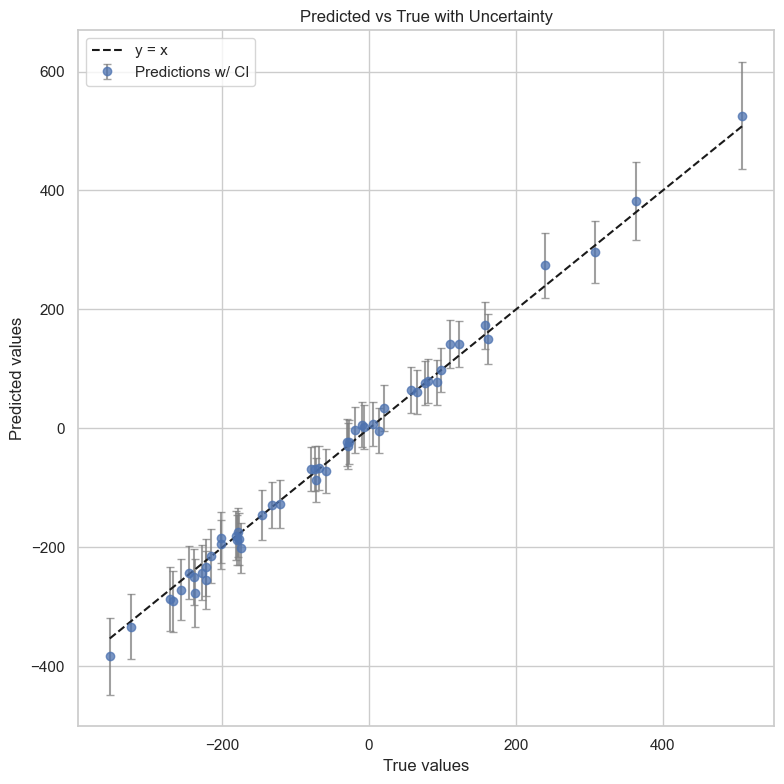

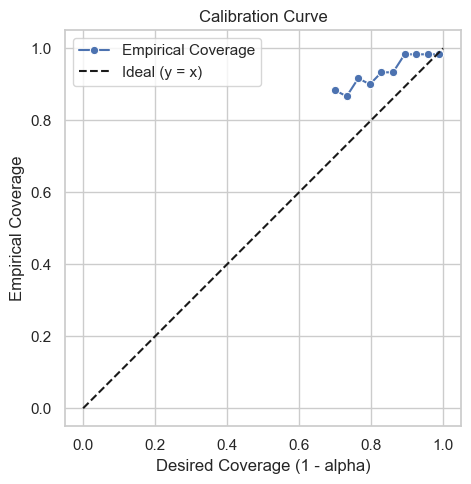

In [21]:
# 5. Visualize Prediction Intervals using UQRegressors plotting utilities
from uqregressors.plotting.plotting import plot_pred_vs_true, generate_cal_curve, plot_cal_curve

# Predicted vs True plot
plot_pred_vs_true(mean, lower, upper, y_test, samples=50, include_confidence=True, show=True, title="Predicted vs True with Uncertainty")

# Calibration curve
alphas = np.linspace(0.01, 0.3, 10)
desired_coverage, coverages, avg_widths = generate_cal_curve(mcd, X_test, y_test, alphas=alphas, refit=False)
plot_cal_curve(desired_coverage, coverages, show=True, title="Calibration Curve")

In [22]:
# 6. Evaluate Prediction Quality
metrics = compute_all_metrics(mean, lower, upper, y_test, mcd.alpha)
print("\nPrediction and Uncertainty Metrics:")
for k, v in metrics.items():
    print(f"    {k}: {v}")


Prediction and Uncertainty Metrics:
    rmse: 17.441155951585564
    coverage: 0.9833333333333333
    average_interval_width: 88.6605641523997
    interval_score: 89.08682763819365
    nll_gaussian: 4.273782332352531
    error_width_corr: 0.44146893491167954
    RMSCD: 0.06009252125773317
    RMSCD_under: 0.11666666666666659
    lowest_group_coverage: 0.8333333333333334
